In [1]:
#### Setting up ####
import os
import re
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy

from matplotlib.colors import LinearSegmentedColormap

sc.settings.savefigs = False

mpl.rcParams['figure.figsize'] = [4.0, 4.0]
mpl.rcParams['grid.alpha'] = 0.0

sc.settings.verbosity = 3
sc.logging.print_header()

#### Loading Data ####
os.chdir("file directory")
filename_BuffyC1 = "filtered_feature_bc_matrix.h5"

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


scanpy==1.7.2 anndata==0.7.5 umap==0.4.6 numpy==1.20.2 scipy==1.5.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
# Reading in actual 10x file
adata = sc.read_10x_h5(filename_BuffyC1, gex_only=True)
adata.var_names_make_unique()

reading filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:08)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata

AnnData object with n_obs × n_vars = 7336 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

normalizing counts per cell
    finished (0:00:00)


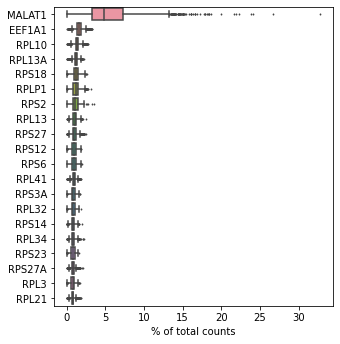

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 47 cells that have less than 500 genes expressed
filtered out 15969 genes that are detected in less than 3 cells


... storing 'feature_types' as categorical
... storing 'genome' as categorical


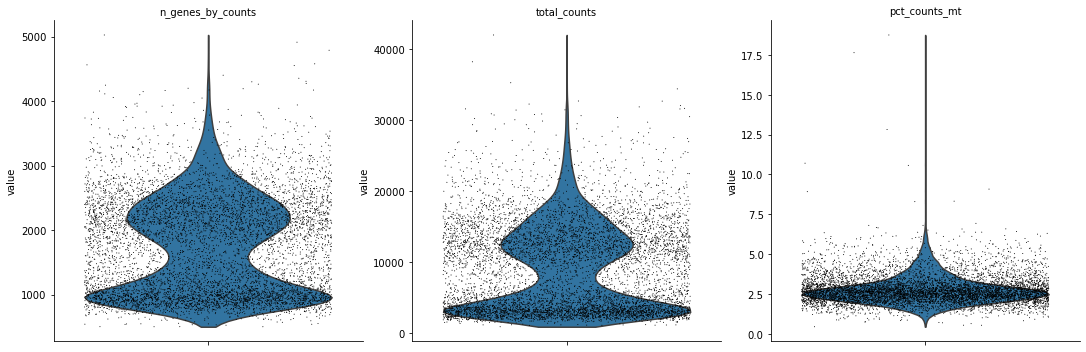

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

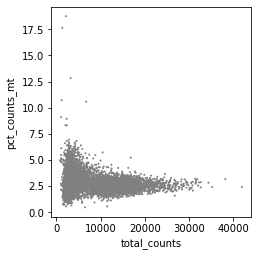

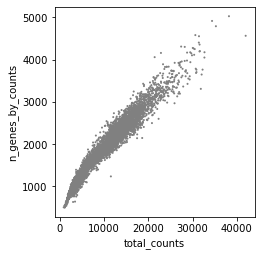

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
# Previous landscape annotation based on 30% mt cutoff
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


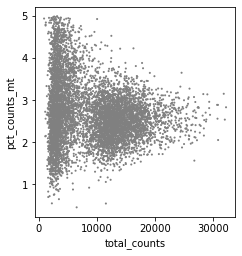

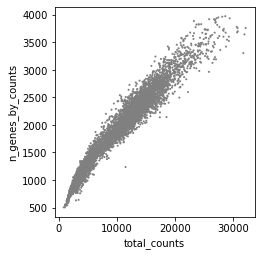

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata_gene_full = adata.copy()
adata.raw = adata
sc.pp.recipe_zheng17(adata, log=True)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:00)


Preprocessing...


/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 46.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.0%
Elapsed time: 5.8 seconds


200

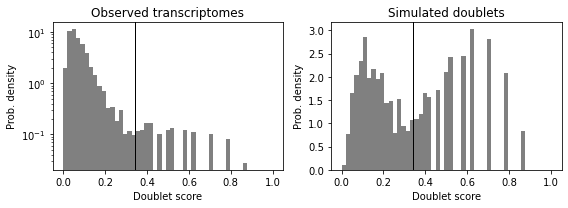

In [12]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [13]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


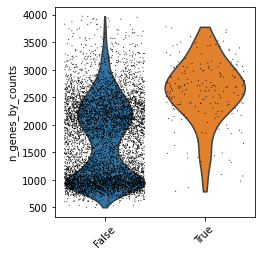

In [14]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [15]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


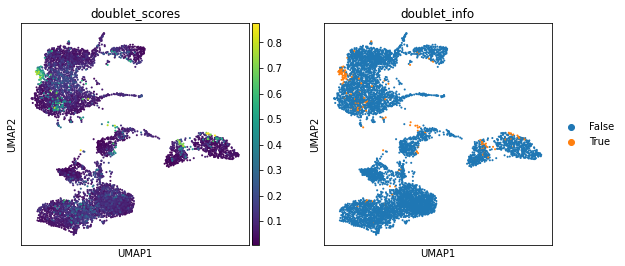

In [16]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info'])

In [17]:
print(adata.shape)
adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(7074, 1000)
(6874, 1000)


/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
adata = adata.raw.to_adata() 
adata = adata[adata.obs['doublet_info'] == 'False',:]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 6874 × 17569
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts_all', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p', 'doublet_info_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [20]:
adata_gene_full = adata.copy()
adata.raw = adata
sc.pp.recipe_zheng17(adata, log=True)

running recipe zheng17
filtered out 2 genes that are detected in less than 1 counts
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:00)


In [21]:
# Normalise "raw counts" layer
adata2 = sc.AnnData(X=adata_gene_full.X, var=adata_gene_full.var, obs=adata_gene_full.obs)
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
adata.raw = adata2

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [22]:
# Loading and removal of cell cycle genes
cell_cycle_genes_file = 'reactome_human_cell_cycle.txt'
with open(cell_cycle_genes_file) as f: 
    cell_cycle_genes = [line.strip('\n') for line in f.readlines()]

# Identify genes correlating with cell cycle genes and remove
gene_correlation = np.corrcoef(adata.X.transpose())
gene_correlation_cell_cycle = gene_correlation[
    [i for i, gene in enumerate(adata.var_names) if gene in cell_cycle_genes], :]

high_correlation_gene_filter = np.amax(gene_correlation_cell_cycle, axis=0) < 0.2
cell_cycle_removed_genes = adata.var_names[np.invert(high_correlation_gene_filter)]
adata = adata[:, high_correlation_gene_filter]

# See how many cells and genes left after filtering
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data have', nGenes, 'genes in', nCells, 'cells')

Data have 772 genes in 6874 cells


/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [23]:
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15)
# sc.tl.louvain(adata)
# Optimum reso is n=15, reso was 0.8 thus far
sc.tl.leiden(adata, resolution=0.5)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


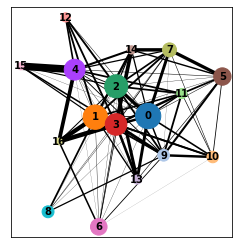

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [24]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color='leiden')
sc.tl.umap(adata)

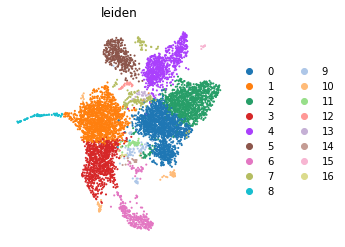

In [25]:
sc.pl.umap(adata, color='leiden', frameon=False) #, save='annotated_11Jun21.pdf'

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


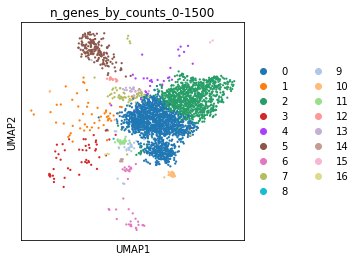

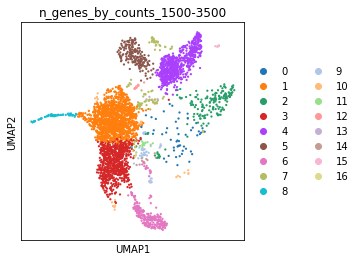

In [26]:
index_range = []
for i, n in adata.obs['n_genes_by_counts'].iteritems():
    if 0 <= n <= 1500:
        index_range.append(i)

sc.pl.umap(adata[adata.obs.loc[index_range].index.tolist(),]
           , color= 
['leiden'], size=20, title='n_genes_by_counts_0-1500')

index_range2 = []
for i, n in adata.obs['n_genes_by_counts'].iteritems():
    if 1500 <= n <= 3500:
        index_range2.append(i)

sc.pl.umap(adata[adata.obs.loc[index_range2].index.tolist(),]
           , color= 
['leiden'], size=20,title='n_genes_by_counts_1500-3500')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


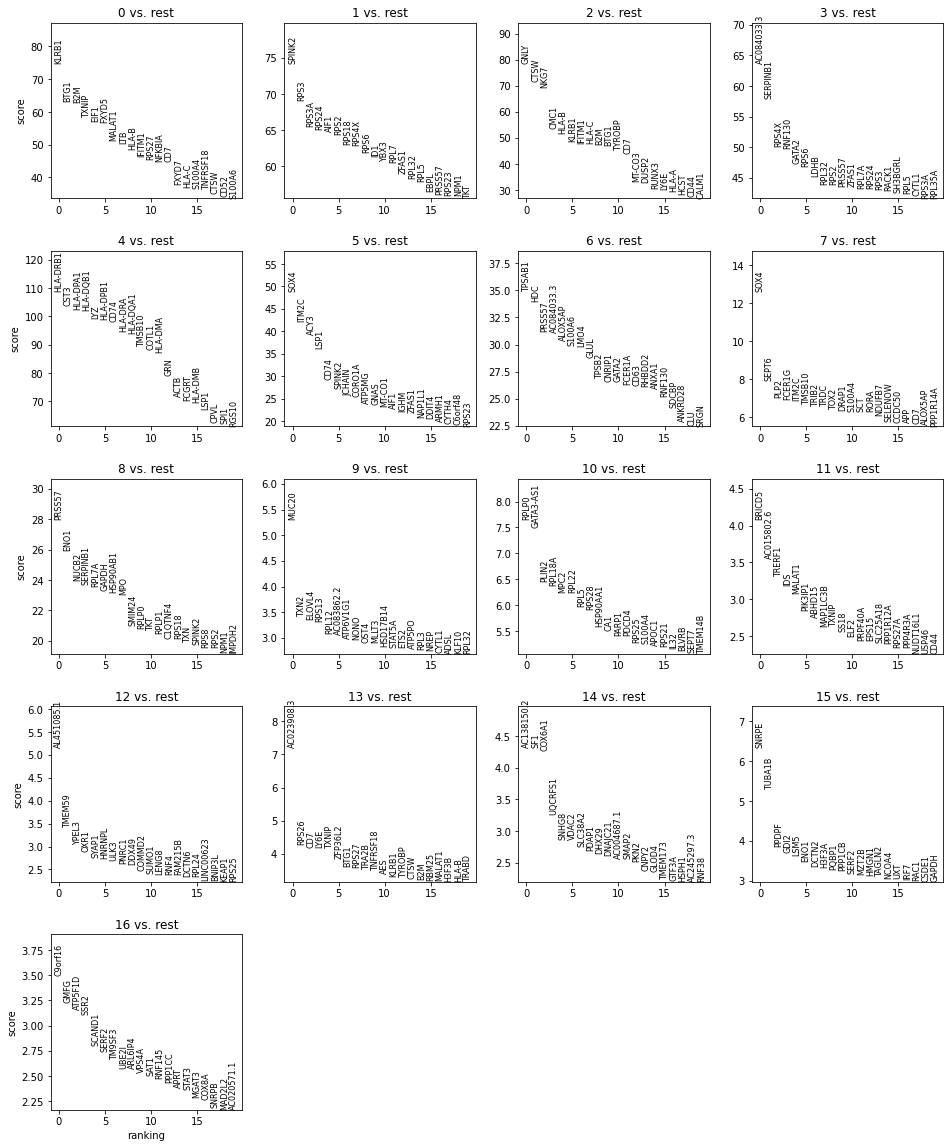

In [27]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups(adata, sharey=False)

In [28]:
Dahlin_marker_genes_revised = {'MCP-like': ['GATA2', 'CPA3', 'TPSB2', 'IL3RA', 'IL5RA', 'CLC', 'CSF2RB', 'HDC', 'TPSD1', 'HPGDS'],
'Neu': ['ELANE', 'MPO', 'PRTN3', 'AZU1'],
'Ery': ['KLF1', 'HBB', 'CA1'],
'HSCs': ['SPINK2', 'CRHBP', 'PCDH9', 'AVP'],
'DC': ['CLEC9A', 'IRF8', 'MPEG1'],
'Mono': ['S100A9', 'LYZ', 'MS4A6A', 'ANXA2', 'CSF1R'],
'Lym': ['DNTT', 'CD79A', 'VPREB1'],
'MK': ['ITGA2B'],
'B': ['JCHAIN', 'IGHM', 'MS4A1'],
'NK': ['LTB', 'KLRB1', 'IL7R', 'NKG7']}

In [29]:
# Create a color_map for clearer annotation
color_list = ['lightgrey', 'silver', 'coral', 'darkred']
cmap = LinearSegmentedColormap.from_list("color_trial", colors=color_list)
color_list_less_grey = ['lightgrey', 'tomato', 'firebrick', 'darkred']
cmap_less_grey = LinearSegmentedColormap.from_list("color_trial", colors=color_list_less_grey)

In [30]:
adata.raw.shape

(6874, 17569)

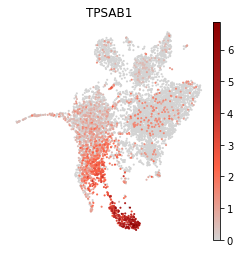

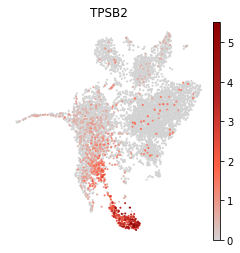

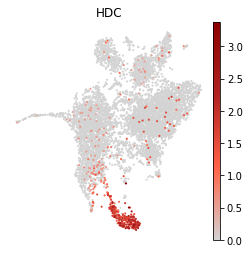

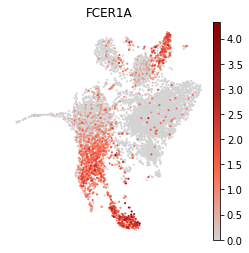

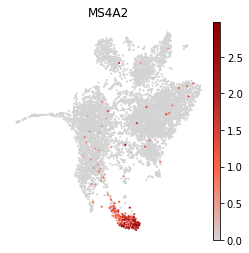

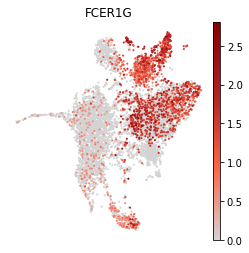

In [31]:
cluster_A_markers = ['TPSAB1', 'TPSB2', 'HDC', 'FCER1A', 'MS4A2', 'FCER1G']
for gene in cluster_A_markers:
    sc.pl.umap(adata, color=gene, use_raw=True, 
                   color_map=cmap_less_grey, frameon=False,
                  #save=str('clusterA' + gene + '11Jun2021' + '.pdf')
              )

MCP-like


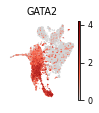

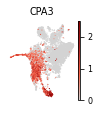

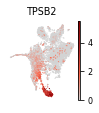

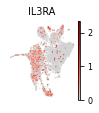

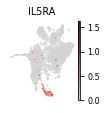

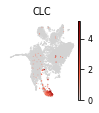

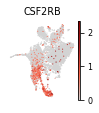

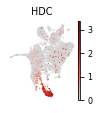

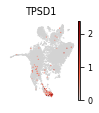

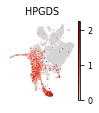

Neu


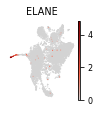

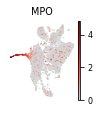

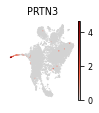

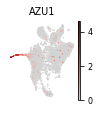

Ery


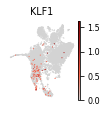

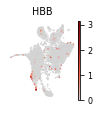

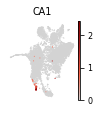

HSCs


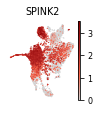

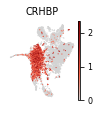

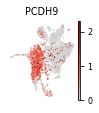

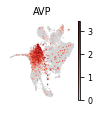

DC


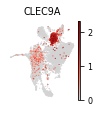

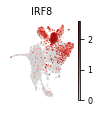

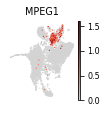

Mono


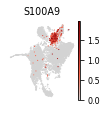

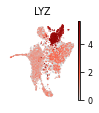

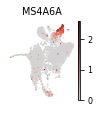

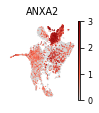

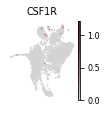

Lym


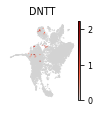

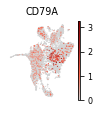

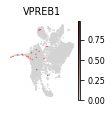

MK


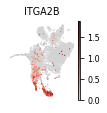

B


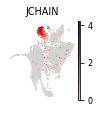

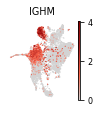

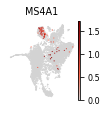

NK


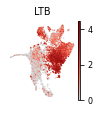

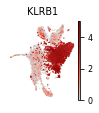

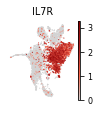

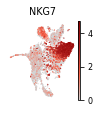

In [32]:
for cell_group, genes in Dahlin_marker_genes_revised.items():
    print(cell_group)
    for gene in genes:
        font = {'size'   : 8}
        mpl.rc('font', **font)
        mpl.rcParams['figure.figsize'] = [1.3750, 1.4583]
        mpl.rcParams['savefig.dpi'] = 200
        sc.pl.umap(adata, color=[gene], use_raw=True, 
                   color_map=cmap_less_grey, frameon=False,
                  #save=str(cell_group + gene + '10Jun2021' + '.png'),
                  #title=f"$\mathit{{{gene}}}$",
                  size=5)

In [33]:
mpl.rcParams['figure.figsize'] = [4, 4]

MCP-like


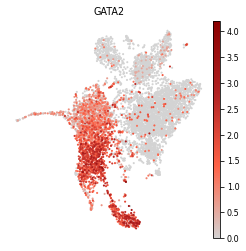

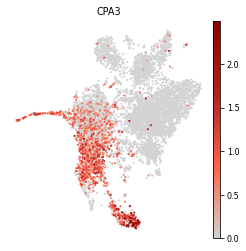

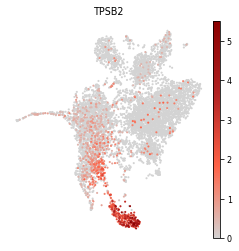

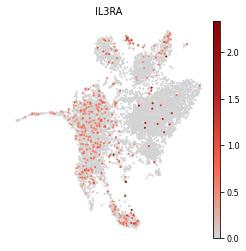

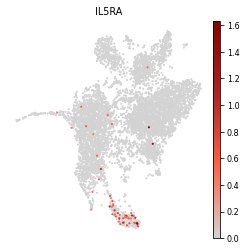

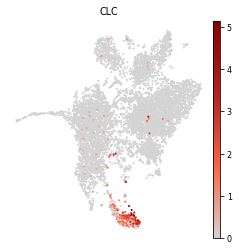

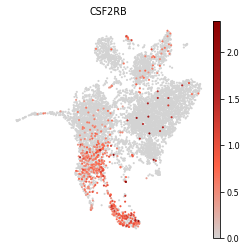

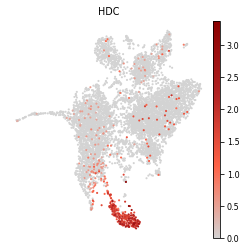

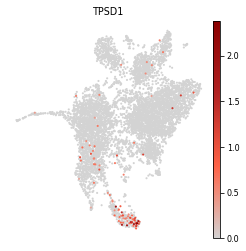

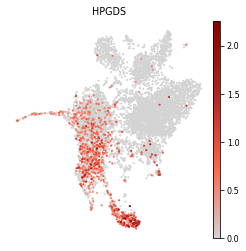

Neu


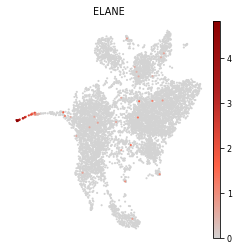

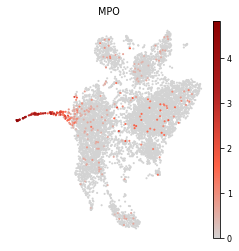

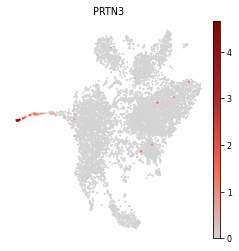

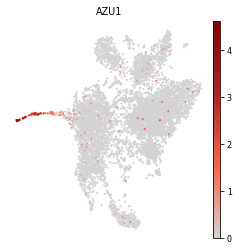

Ery


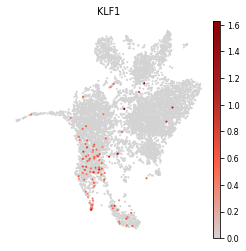

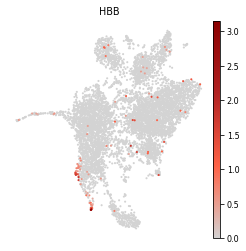

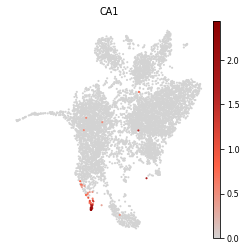

HSCs


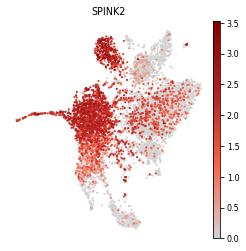

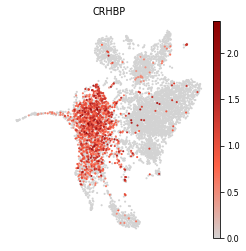

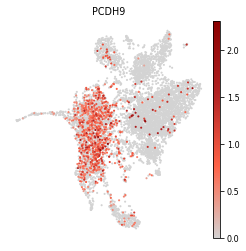

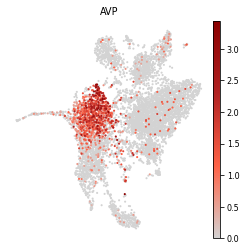

DC


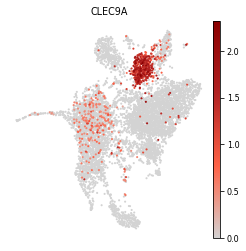

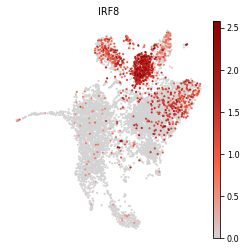

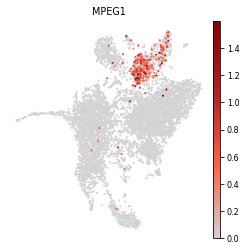

Mono


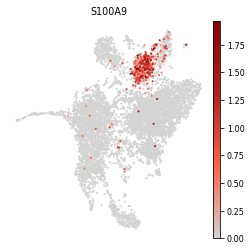

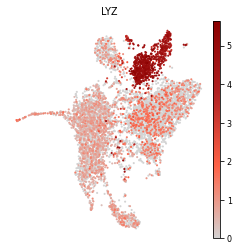

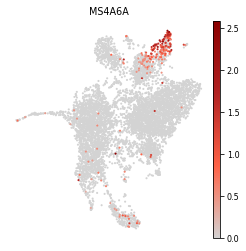

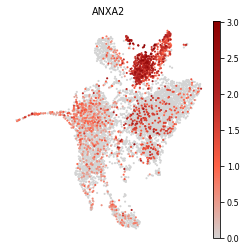

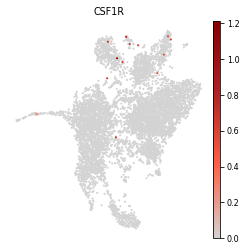

Lym


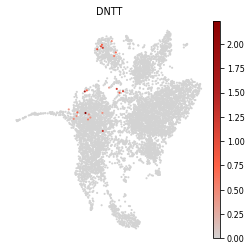

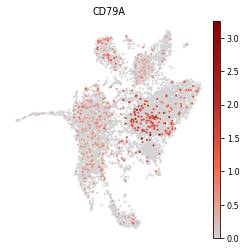

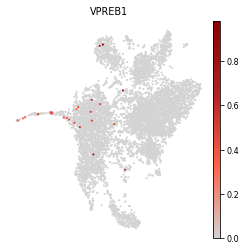

MK


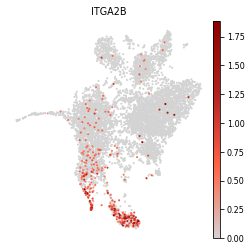

B


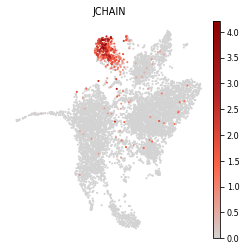

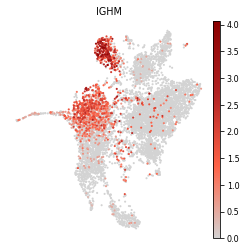

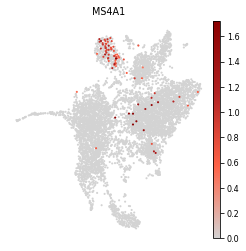

NK


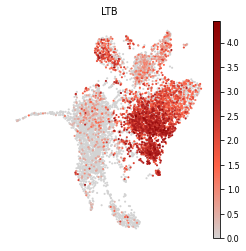

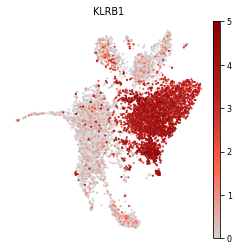

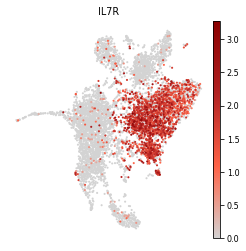

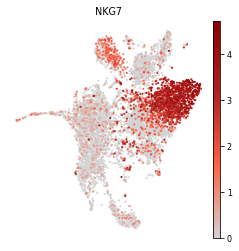

In [34]:
for cell_group, genes in Dahlin_marker_genes_revised.items():
    print(cell_group)
    for gene in genes:
        sc.pl.umap(adata, color=[gene], use_raw=True, 
                   color_map=cmap_less_grey, frameon=False,
                  #save=str(cell_group + gene + '2Jun2021' + '.png')
                  )

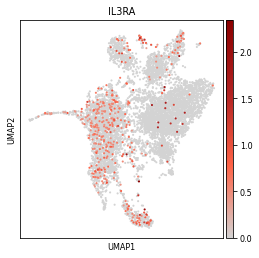

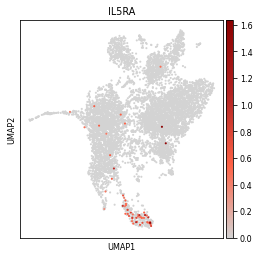

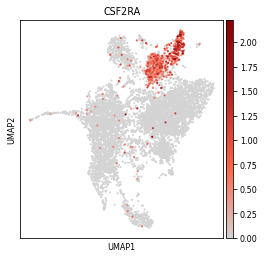

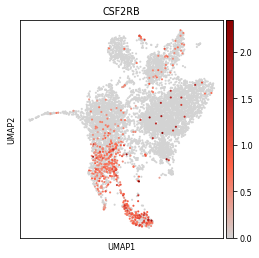

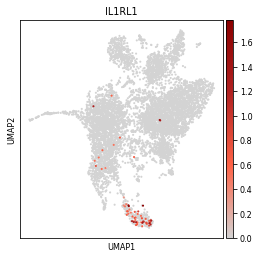

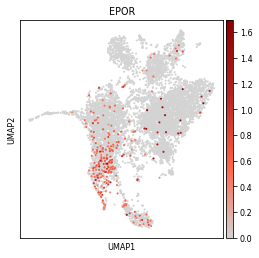

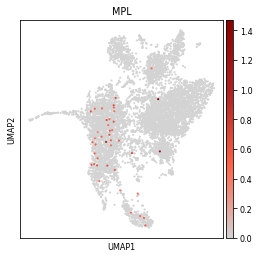

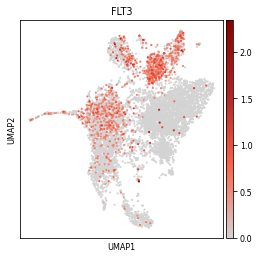

In [35]:
cytokine_receptors = ['IL3RA', 'IL5RA', 'CSF2RA', 'CSF2RB', 'IL1RL1', 'EPOR', 'MPL', 'FLT3']
for gene in cytokine_receptors:
    sc.pl.umap(adata, color=gene, color_map=cmap_less_grey, use_raw=True,
              #save=str('/cytokines/' + gene + '2Jun2021')
              )

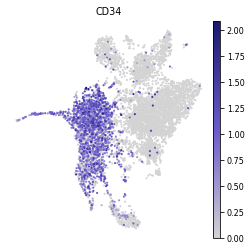

In [36]:
color_list_receptor = ['lightgrey', 'slateblue', 'midnightblue']
cmap_receptor = LinearSegmentedColormap.from_list("color_trial", colors=color_list_receptor)
sc.pl.umap(adata, color='CD34', color_map=cmap_receptor, use_raw=True,
           #save='CD34_2Jun2021',
          frameon=False)

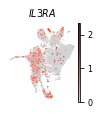

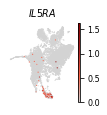

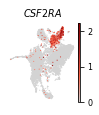

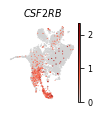

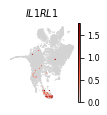

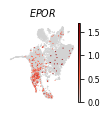

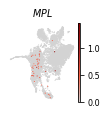

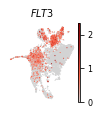

In [37]:
cytokine_receptors = ['IL3RA', 'IL5RA', 'CSF2RA', 'CSF2RB', 'IL1RL1', 'EPOR', 'MPL', 'FLT3']
for gene in cytokine_receptors:    
    font = {'size'   : 8}
    mpl.rc('font', **font)
    mpl.rcParams['figure.figsize'] = [1.3750, 1.4583]
    mpl.rcParams['savefig.dpi'] = 200
    sc.pl.umap(adata, color=[gene], use_raw=True, 
                   color_map=cmap_less_grey, frameon=False,
                  #save=str('/cytokines/' + gene + '10Jun2021' + '.png'),
                  title=f"$\mathit{{{gene}}}$",
                  size=5)